# Quant GAN
## Tensor Flow Version
[Wiese et al., Quant GANs: Deep Generation of Financial Time Series, 2019](https://arxiv.org/abs/1907.06673)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from preprocess.acf import *
from preprocess.gaussianize import *

from tensorflow.random import normal
from tensorflow.keras.models import load_model
#from google.colab import files
from model.tf_gan import GAN
from model.tf_tcn import *

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


input_dim: [1, None, 3]
kernel_size: 1  dilation: 1, fixed_filters: 80 cropping: 0
kernel_size: 2  dilation: 1, fixed_filters: 80 cropping: 0
kernel_size: 2  dilation: 2, fixed_filters: 80 cropping: 2
kernel_size: 2  dilation: 4, fixed_filters: 80 cropping: 6
kernel_size: 2  dilation: 8, fixed_filters: 80 cropping: 14
kernel_size: 2  dilation: 16, fixed_filters: 80 cropping: 30
kernel_size: 2  dilation: 32, fixed_filters: 80 cropping: 62
input_dim: [1, 127, 1]
kernel_size: 1  dilation: 1, fixed_filters: 80 cropping: 0
kernel_size: 2  dilation: 1, fixed_filters: 80 cropping: 0
kernel_size: 2  dilation: 2, fixed_filters: 80 cropping: 2
kernel_size: 2  dilation: 4, fixed_filters: 80 cropping: 6
kernel_size: 2  dilation: 8, fixed_filters: 80 cropping: 14
kernel_size: 2  dilation: 16, fixed_filters: 80 cropping: 30
kernel_size: 2  dilation: 32, fixed_filters: 80 cropping: 62


C:\Users\User\AppData\Local\Temp\ipykernel_20312\3350617735.py:9: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv(file_path, parse_dates={'datetime': ['Date']}, date_parser=dateparse)


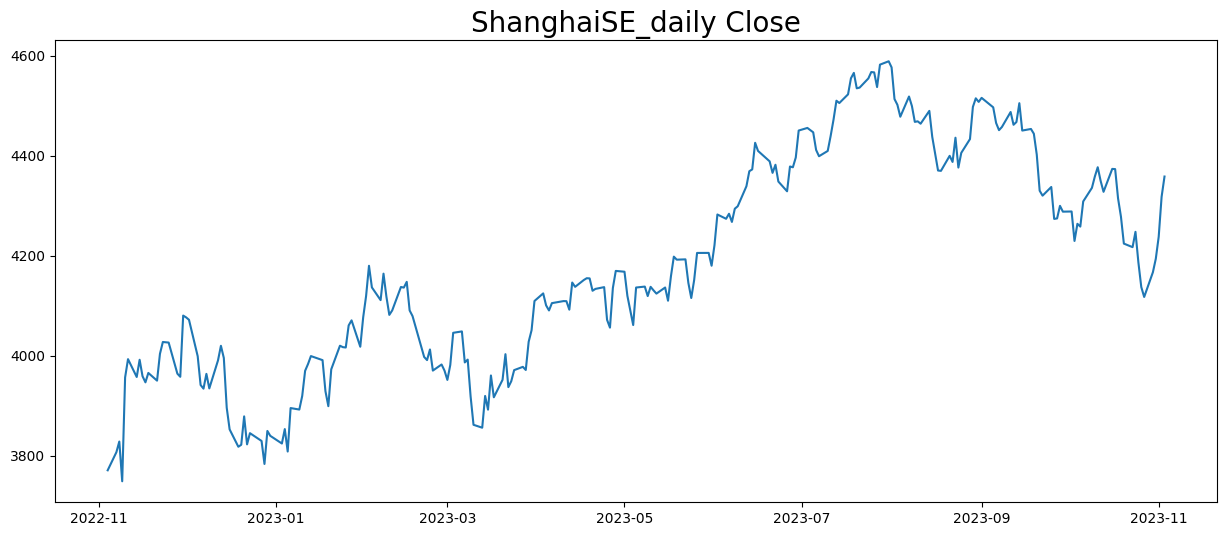

In [2]:
file_name = "ShanghaiSE_daily"
file_path = "data/"+file_name+".csv"
generator_path = ""


def dateparse(d):
    return pd.Timestamp(d)

data = pd.read_csv(file_path, parse_dates={'datetime': ['Date']}, date_parser=dateparse)
df = data['CLOSE']
fig = plt.figure(figsize=(15,6))
plt.title(f'{file_name} Close', fontsize=20)
plt.plot(data['datetime'], data['CLOSE'] )
plt.show()
# confirm data loaded

## Preprocess data
 For more details see [preprocess.ipynb](./preprocess.ipynb)

In [3]:
returns = df.shift(1)/df - 1
log_returns = np.log(df/df.shift(1))[1:].to_numpy().reshape(-1, 1)
standardScaler1 = StandardScaler()
standardScaler2 = StandardScaler()
gaussianize = Gaussianize()
log_returns_preprocessed = standardScaler2.fit_transform(gaussianize.fit_transform(standardScaler1.fit_transform(log_returns)))
receptive_field_size = 127  # p. 17
log_returns_rolled = rolling_window(log_returns_preprocessed, receptive_field_size)
data_size = log_returns.shape[0]
print(data_size)

250


## Train model
 For more details see [tf_model.ipynb](./tf_model.ipynb)

In [4]:
train = True

if train:
  gan = GAN(discriminator, generator, 2 * receptive_field_size - 1, lr_d=1e-4, lr_g=3e-5)
  gan.acf_real = acf(log_returns_preprocessed, 250)
  gan.abs_acf_real = acf(log_returns_preprocessed**2, 250)
  gan.le_real = acf(log_returns_preprocessed, 250, le=True)
  gan.fixed_noise = normal([128, 1, data_size + receptive_field_size - 1, 3])
  data = np.expand_dims(np.moveaxis(log_returns_rolled, 0,1), 1).astype('float32')
  batch_size = 64
  n_batches = 10
  gan.train(data, batch_size, n_batches)
  generator.save(f'trained_generator_{file_name}')
  #zip -r trained_generator_{file_name}.zip trained_generator_{file_name}/
  #files.download(f'trained_generator_{file_name}.zip')
else:
  print(f"Loading: {generator_path}trained_generator_{file_name}")
  generator = load_model(f"{generator_path}trained_generator_{file_name}")
  # generator = load_model(f"/temporalCN/trained/trained_generator_ShanghaiSE_daily")


c:\Users\User\Desktop\QuantGAN\preprocess\acf.py:40: RuntimeWarning: invalid value encountered in divide
  return np.nansum((a * b), axis=1) / np.sqrt(np.nansum(a**2, axis=0) * np.nansum(b**2, axis=1))


10/10 [==============================] - 66s 2s/step
INFO:tensorflow:Assets written to: trained_generator_ShanghaiSE_daily\assets


INFO:tensorflow:Assets written to: trained_generator_ShanghaiSE_daily\assets


## Generate

In [5]:
noise = normal([512, 1, len(log_returns_preprocessed) + receptive_field_size - 1, 3])
y = generator(noise).numpy().squeeze()

y = (y - y.mean(axis=0))/y.std(axis=0)
y = standardScaler2.inverse_transform(y)
y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = standardScaler1.inverse_transform(y)

# some basic filtering to redue the tendency of GAN to produce extreme returns
y = y[(y.max(axis=1) <= 2 * log_returns.max()) & (y.min(axis=1) >= 2 * log_returns.min())]
# y -= y.mean()


Text(0, 0.5, 'Cumalative Log Return')

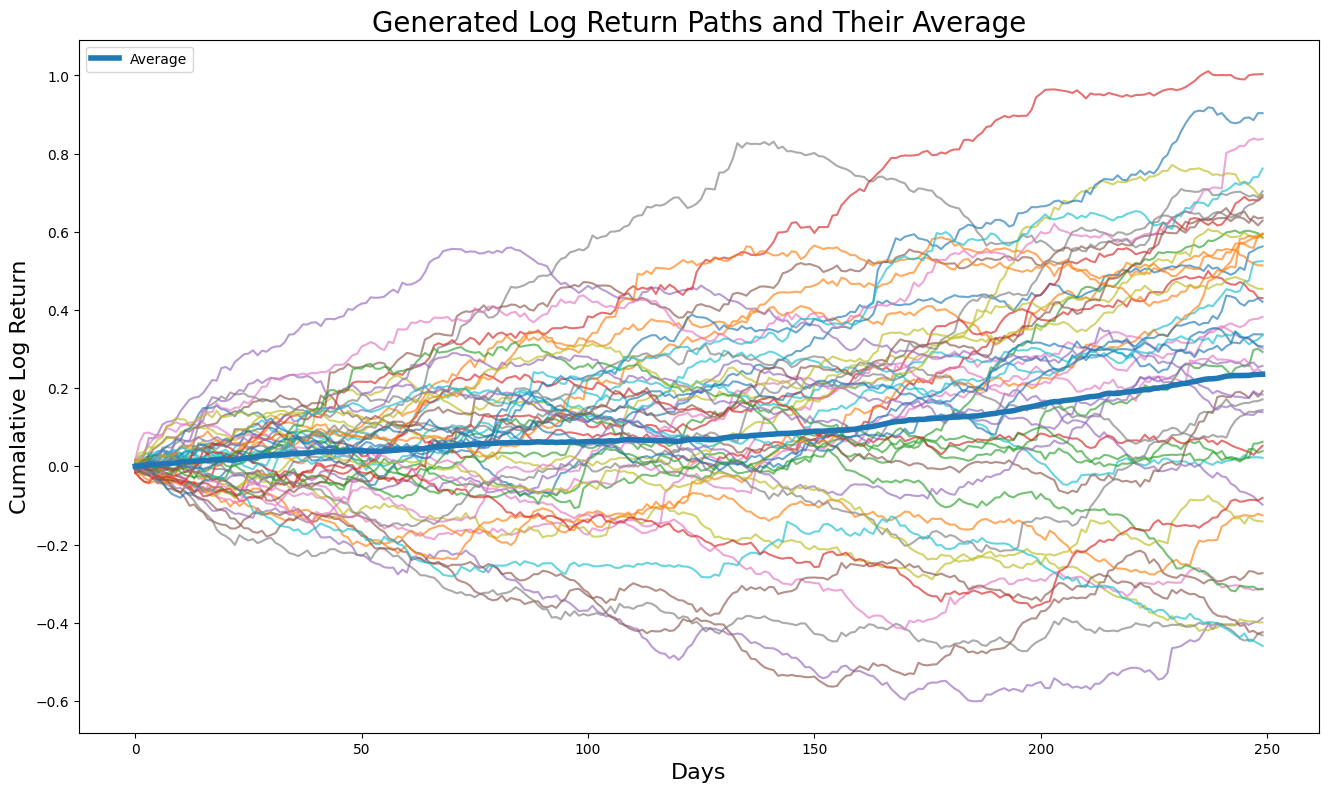

In [6]:
ySum = y[0:100].cumsum(axis=1).mean(axis=0)

fig, ax = plt.subplots(figsize=(16,9))
ax.plot(ySum, alpha=1, lw = 4, zorder = 2)
ax.plot(np.cumsum(y[0:50], axis=1).T, alpha=0.65, zorder = 1)
ax.legend(['Average'])

ax.set_title('Generated Log Return Paths and Their Average'.format(len(y)), fontsize=20)
ax.set_xlabel('Days', fontsize=16)
ax.set_ylabel('Cumalative Log Return', fontsize=16)

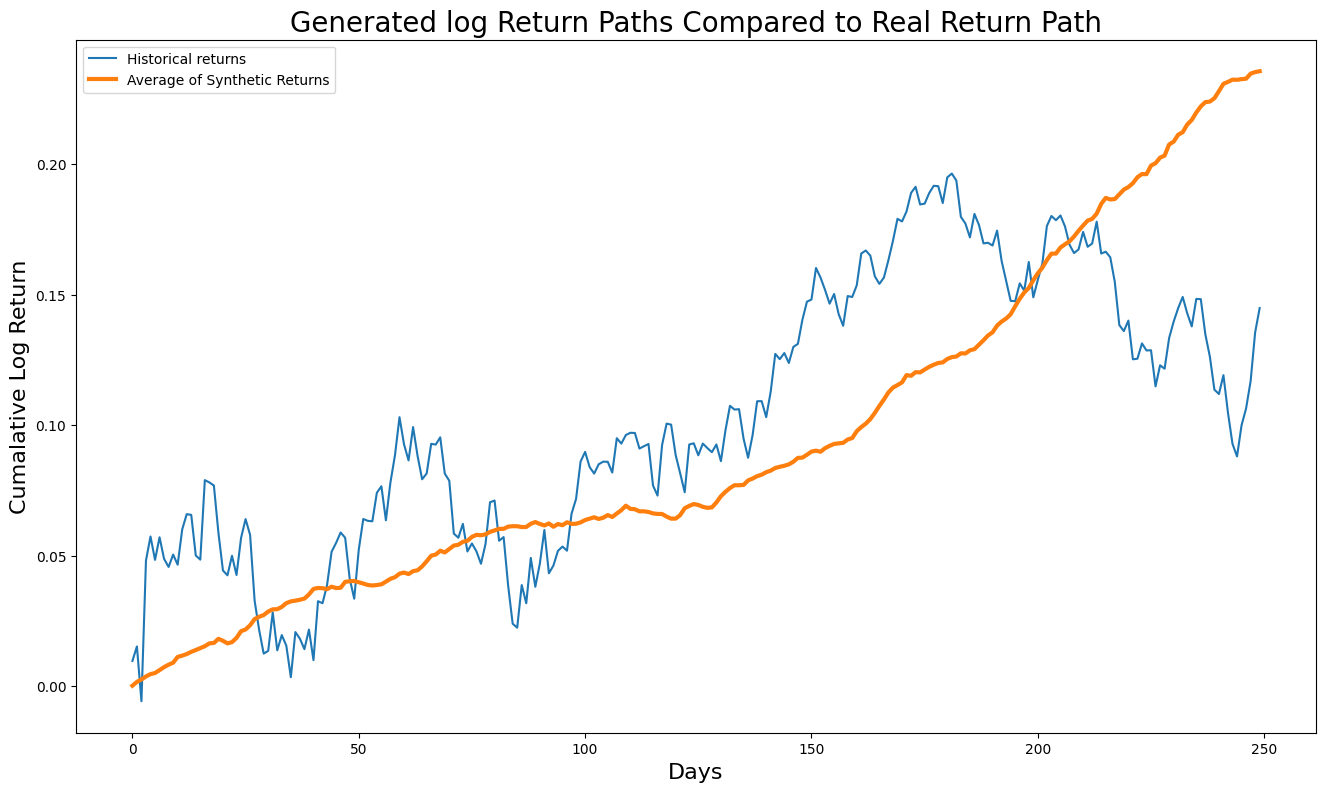

In [7]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.cumsum(log_returns, axis=0))
ax.set_title('Generated log Return Paths Compared to Real Return Path'.format(len(y)), fontsize=20)
ax.set_xlabel('Days', fontsize=16)
ax.set_ylabel('Cumalative Log Return', fontsize=16)

#for i in [105, 150, 200]:
#    ax.plot(y[100:i].cumsum(axis=1).mean(axis=0))
ax.plot(ySum, alpha=1, lw = 3)

ax.legend(['Historical returns', 'Average of Synthetic Returns'])


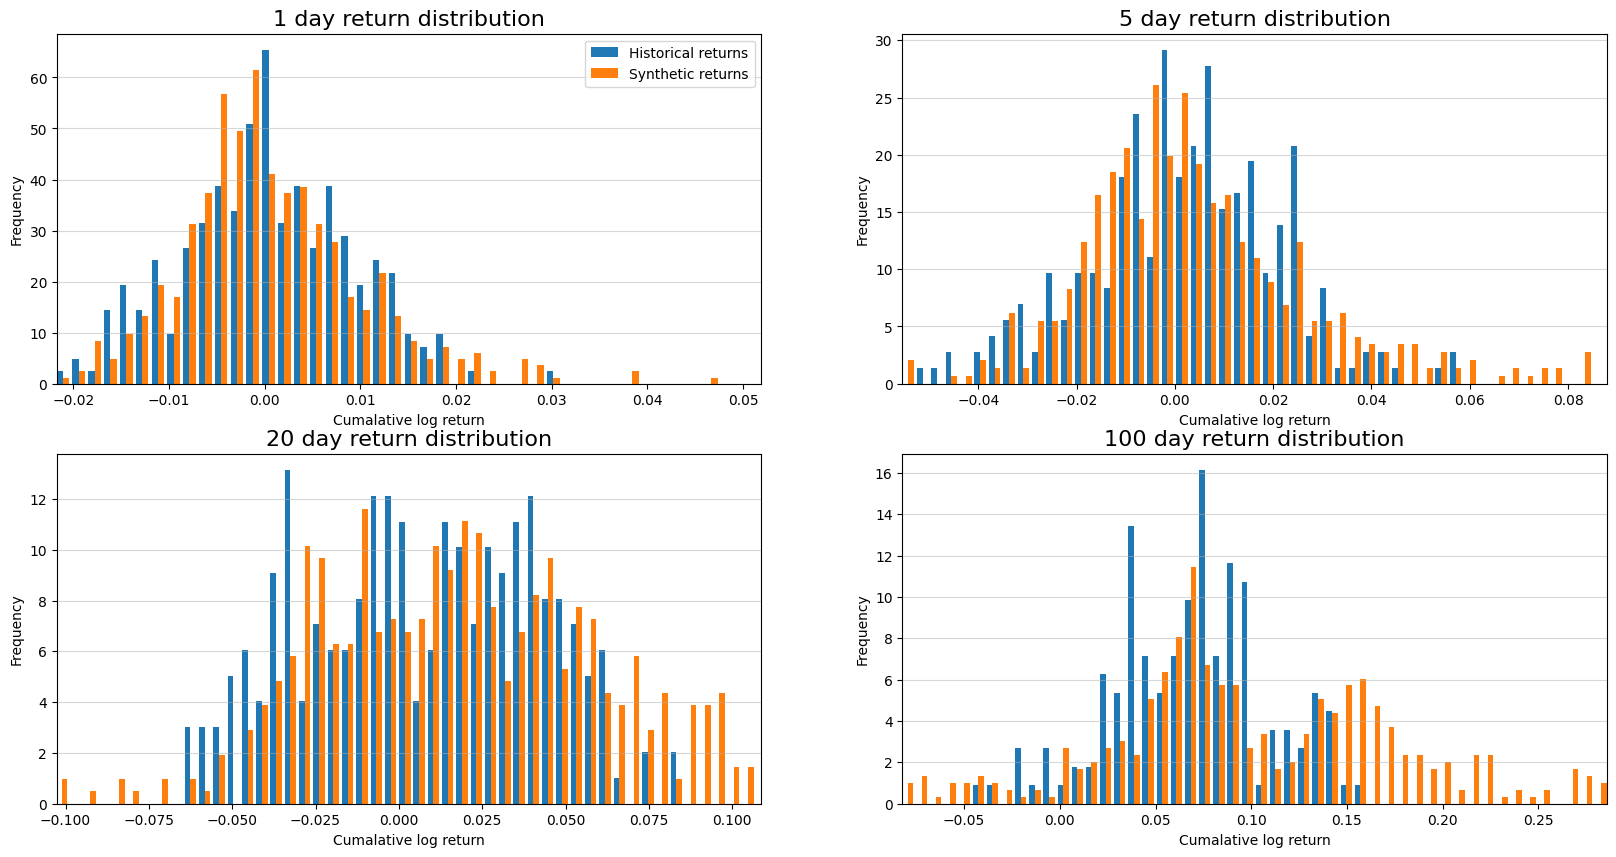

In [8]:
n_bins = 50
windows = [1, 5, 20, 100]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))


for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    col = i % 2
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T[1][:], windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    axs[row, col].hist(np.array([real_dist, fake_dist], dtype='object'), bins=50, density=True)
    axs[row,col].set_xlim(*np.quantile(fake_dist, [0.001, .999]))
    
    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=16)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].set_xlabel('Cumalative log return')
    axs[row,col].set_ylabel('Frequency')

axs[0,0].legend(['Historical returns', 'Synthetic returns'])


[Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days')]

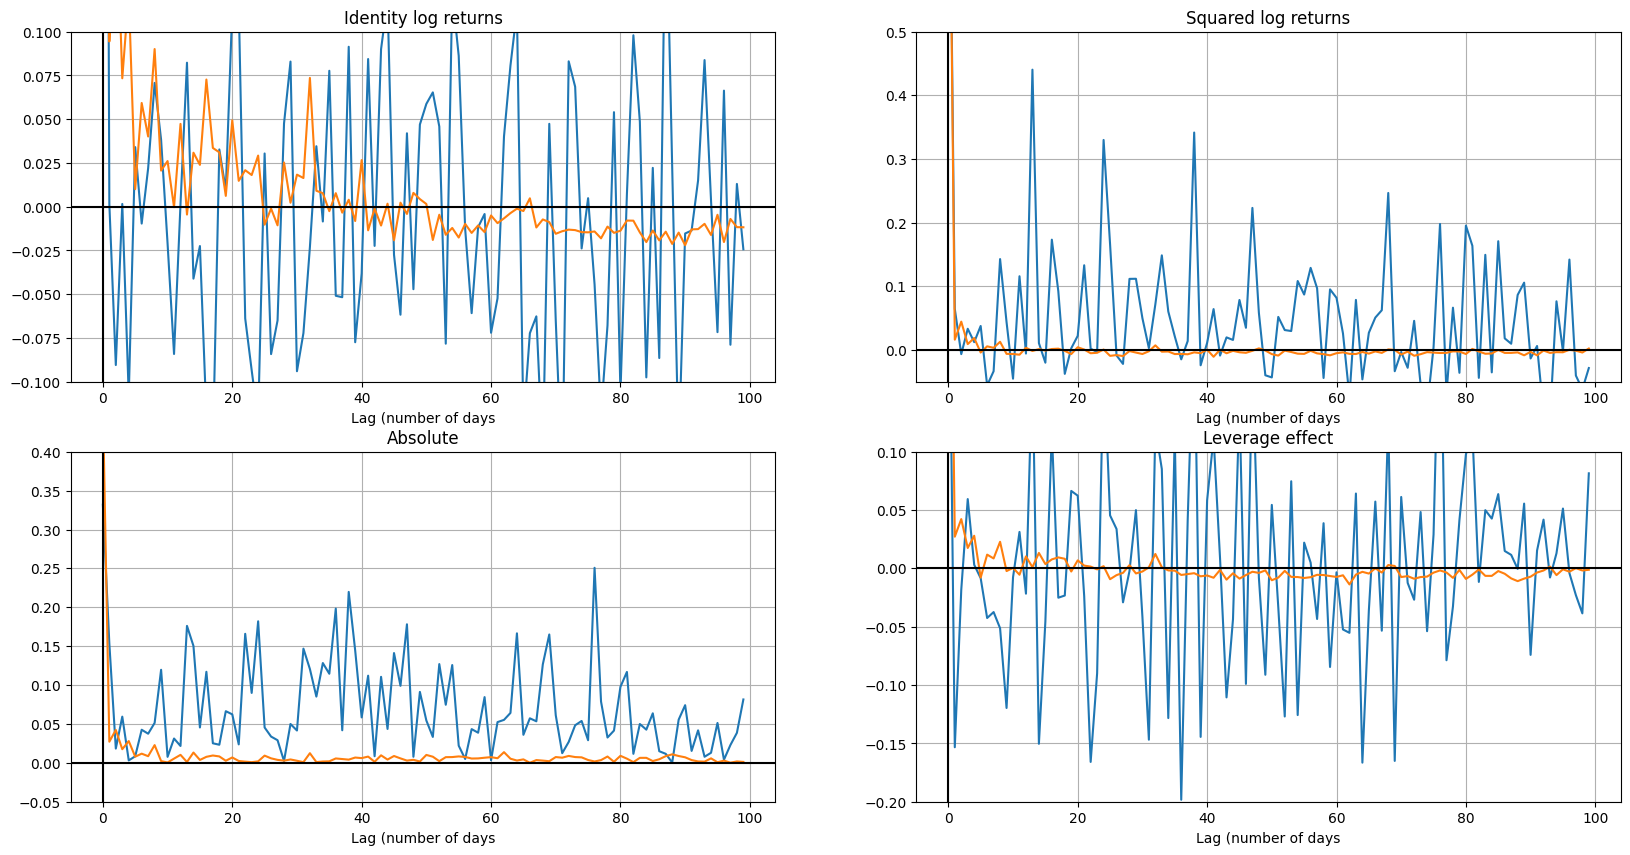

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

axs[0,0].plot(acf(log_returns, 100))
axs[0,0].plot(acf(y.T, 100).mean(axis=1))
axs[0,0].set_ylim(-0.1, 0.1)
axs[0,0].set_title('Identity log returns')
axs[0,1].plot(acf(log_returns**2, 100))
axs[0,1].set_ylim(-0.05, 0.5)
axs[0,1].plot(acf(y.T**2, 100).mean(axis=1))
axs[0,1].set_title('Squared log returns')
axs[1,0].plot(abs(acf(log_returns, 100, le=True)))
axs[1,0].plot(abs(acf(y.T, 100, le=True).mean(axis=1)))
axs[1,0].set_ylim(-0.05, 0.4)
axs[1,0].set_title('Absolute')
axs[1,1].plot(acf(log_returns, 100, le=True))
axs[1,1].plot(acf(y.T, 100, le=True).mean(axis=1))
axs[1,1].set_ylim(-0.2, 0.1)
axs[1,1].set_title('Leverage effect')


for ax in axs.flat: 
  ax.grid(True)
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
plt.setp(axs, xlabel='Lag (number of days')